<a href="https://colab.research.google.com/github/satyajitghana/ProjektDepth/blob/master/notebooks/11_DepthModel_ModelTrain_PlayWithLossFunctions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing various loss functions

In [0]:
! nvidia-smi

Fri May 22 08:47:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
! pip install kornia

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pathlib import Path
from zipfile import ZipFile
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import gc
from tqdm.auto import tqdm, trange
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchsummary import summary
import torch.nn as nn
import torchvision.transforms as T
import glob
import torch
import sys
from typing import List, Tuple
import yaml
import numpy as np
import time
import torch.nn.functional as F
import torch.optim as optim
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.debug.metrics as met
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.utils.utils as xu
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
sys.path.insert(0, 'ProjektDepth')

In [0]:
! git clone https://github.com/satyajitghana/ProjektDepth.git

Cloning into 'ProjektDepth'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 70 (delta 31), reused 54 (delta 17), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [0]:
import vathos.data_loader as vloader
import vathos.model as vmodel

In [0]:
from pathlib import Path
import os
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import PIL
import zipfile
from zipfile import ZipFile
sns.set()

class DenseDepth(Dataset):
    '''
    DenseDepth Dataset

    Args:
        root: the directory where to place the dataset unzipped files
        source_zipfiles: the directory where the dataset zip files are stored (mount your drive and give a absolute path)
        transform: torchvision transform for input images
        target_transform: torchvision transform for ouput images

    Input is fg_bg image AND bg image
    Target is fg_bg_mask AND depth_fg_bg image

    '''

    source_zipfiles = ['bg_small.zip', 'fg_bg_small.zip',
                       'fg_bg_mask_small.zip', 'depth_fg_bg_small.zip']

    bg_stat = (['0.573435604572296', '0.520844697952271', '0.457784473896027'], [
               '0.207058250904083', '0.208138316869736', '0.215291306376457'])
    fg_bg_stat = (['0.568499565124512', '0.512103974819183', '0.452332496643066'], [
                  '0.211068645119667', '0.211040720343590', '0.216081097722054'])
    fg_bg_mask_stat = (['0.062296919524670', '0.062296919524670', '0.062296919524670'], [
                       '0.227044790983200', '0.227044790983200', '0.227044790983200'])
    depth_fg_bg_stat = (['0.302973538637161', '0.302973538637161', '0.302973538637161'], [
                        '0.101284727454185', '0.101284727454185', '0.101284727454185'])

    def __init__(self, root, source_zipfolder, train=True, transform=None, target_transform=None):
        self.root = Path(root) / 'Vathos'
        self.root.mkdir(parents=True, exist_ok=True)
        self.source_zipfolder = Path(source_zipfolder)
        self.transform = transform
        self.target_transform = target_transform

        # check if the dataset exists
        if os.path.isdir(self.root / 'bg') or os.path.isdir(self.root / 'fg_bg') or os.path.isdir(self.root / 'fg_bg_mask') or os.path.isdir(self.root / 'depth_fg_bg'):
            print(f'dataset folders/files already exists in {self.root}')
        else:
            # extract the dataset to root dir
            self.extractall()

        # pathlib does not order them by default
        bg_paths = sorted(list(Path(self.root / 'bg').glob('*.jpg')))
        fg_bg_paths = sorted(list(Path(self.root / 'fg_bg').glob('**/*.jpg')))
        fg_bg_mask_paths = sorted(
            list(Path(self.root / 'fg_bg_mask').glob('**/*.jpg')))
        depth_fg_bg_paths = sorted(
            list(Path(self.root / 'depth_fg_bg').glob('**/*.png')))

        assert(len(bg_paths) == 100)
        assert(len(fg_bg_paths) == 400000)
        assert(len(fg_bg_mask_paths) == 400000)
        assert(len(depth_fg_bg_paths) == 400000)

        print(f'found {len(bg_paths)} bg images, {len(fg_bg_paths)} fg_bg images, {len(fg_bg_mask_paths)} fg_bg_mask images, {len(depth_fg_bg_paths)} depth_fg_bg images')

        self.input_paths = fg_bg_paths
        self.bg_paths = bg_paths
        self.target_paths = list(zip(fg_bg_mask_paths, depth_fg_bg_paths))

    def extractall(self):
        print(f'Extracting the zip files')
        for smallzip in tqdm(self.source_zipfiles):
            print(f'Extracting {smallzip} ...')
            zipf = ZipFile(self.source_zipfolder / smallzip, 'r')
            zipf.extractall(self.root)

    def __getitem__(self, index):

        bgidx = self.input_paths[index].stem.split('_')[3]

        bgimg = Image.open(self.bg_paths[int(bgidx)])
        bgimg = bgimg.convert('RGB')
        # bgimg = np.array(bgimg)

        fg_bgimg = Image.open(self.input_paths[index])
        fg_bgimg = fg_bgimg.convert('RGB')
        # fg_bgimg = np.array(fg_bgimg)

        target_mask, target_depth = self.target_paths[index]

        mask_fg_bgimg = Image.open(target_mask)
        mask_fg_bgimg.convert('L')
        mask_arr = np.array(mask_fg_bgimg)
        mask_arr[mask_arr >= 150] = 255
        mask_arr[mask_arr < 150]  = 0
        mask_fg_bgimg = Image.fromarray(mask_arr)
        # mask_fg_bgimg.convert('L')

        depth_fg_bgimg = Image.open(target_depth)
        depth_fg_bgimg.convert('L')

        if self.transform is not None:
            bgimg = self.transform(bgimg)
            fg_bgimg = self.transform(fg_bgimg)

        if self.target_transform is not None:
            mask_fg_bgimg = self.target_transform(mask_fg_bgimg)
            depth_fg_bgimg = self.target_transform(depth_fg_bgimg)

        return {'bg': bgimg, 'fg_bg': fg_bgimg, 'fg_bg_mask': mask_fg_bgimg, 'depth_fg_bg': depth_fg_bgimg}

    def __len__(self):
        return len(self.input_paths)

    @staticmethod
    def plot_sample(sample):
        '''
        Plots a given sample of the dataset
        '''
        bg, fg_bg, fg_bg_mask, depth_fg_bg = sample['bg'].permute(1, 2, 0).numpy(), sample['fg_bg'].permute(
            1, 2, 0).numpy(), sample['fg_bg_mask'][0].numpy(), sample['depth_fg_bg'][0].numpy()
        fig, ax = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

        ax[0, 0].imshow(bg)
        ax[0, 0].axis('off')

        ax[0, 1].imshow(fg_bg)
        ax[0, 1].axis('off')

        ax[1, 0].imshow(fg_bg_mask)
        ax[1, 0].axis('off')

        ax[1, 1].imshow(depth_fg_bg)
        ax[1, 1].axis('off')

        fig.tight_layout()

        plt.show()

    @staticmethod
    def plot4_batch(batch):
        '''
        Plots 4 images for batch
        '''
        fig, ax = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)

        # set the title
        for axs, col in zip(ax[0], ['BG', 'FG_BG', 'FG_BG_MASK', 'DEPTH_FG_BG']):
            axs.set_title(col)

        # plot the first 4 samples from the batch
        for i in range(4):
            bg, fg_bg, fg_bg_mask, depth_fg_bg = batch['bg'][i].permute(1, 2, 0).numpy(), batch['fg_bg'][i].permute(
                1, 2, 0).numpy(), batch['fg_bg_mask'][i][0].numpy(), batch['depth_fg_bg'][i][0].numpy()

            ax[i, 0].imshow(bg)
            ax[i, 0].axis('off')

            ax[i, 1].imshow(fg_bg)
            ax[i, 1].axis('off')

            ax[i, 2].imshow(fg_bg_mask)
            ax[i, 2].axis('off')

            ax[i, 3].imshow(depth_fg_bg)
            ax[i, 3].axis('off')

        fig.tight_layout()

        plt.show()


In [0]:
device = torch.device("cuda:0")

In [0]:
%%time
dataset = DenseDepth(root='data', source_zipfolder='/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/',
                     transform=T.Compose([T.ToTensor()]), target_transform=T.Compose([T.ToTensor()]))

Extracting the zip files


Extracting bg_small.zip ...
Extracting fg_bg_small.zip ...
Extracting fg_bg_mask_small.zip ...
Extracting depth_fg_bg_small.zip ...

found 100 bg images, 400000 fg_bg images, 400000 fg_bg_mask images, 400000 depth_fg_bg images
CPU times: user 1min 27s, sys: 41.8 s, total: 2min 8s
Wall time: 3min 10s


## Split the Data into Test and Train

In [0]:
%%time
# 70 - 30 split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

CPU times: user 38.8 ms, sys: 3.9 ms, total: 42.7 ms
Wall time: 41.2 ms


In [0]:
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

In [0]:
def plot4_batch(batch):
    '''
    Plots 4 images for batch
    '''
    fig, ax = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)

    # set the title
    for axs, col in zip(ax[0], ['BG', 'FG_BG', 'FG_BG_MASK', 'DEPTH_FG_BG']):
        axs.set_title(col)
    
    # plot the first 4 samples from the batch
    for i in range(4):
        bg, fg_bg, fg_bg_mask, depth_fg_bg = batch['bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg_mask'][i][0].cpu().numpy(), batch['depth_fg_bg'][i][0].cpu().numpy()

        ax[i, 0].imshow(bg) ; ax[i, 0].axis('off')

        ax[i, 1].imshow(fg_bg) ; ax[i, 1].axis('off')

        fg_bg_mask[fg_bg_mask >= 0.9] = 1
        fg_bg_mask[fg_bg_mask < 0.9]  = 0

        ax[i, 2].imshow(fg_bg_mask) ; ax[i, 2].axis('off')

        ax[i, 3].imshow(depth_fg_bg) ; ax[i, 3].axis('off')

    fig.tight_layout()

    plt.show()

In [0]:
def plot_results(batch):
    '''
    Plots 4 images for batch's model results
    '''
    fig, ax = plt.subplots(4, 6, figsize=(10, 6), sharex=True, sharey=True)

    # set the title
    for axs, col in zip(ax[0], ['BG', 'FG_BG', 'GT MASK', 'PRED MASK', 'GT DEPTH', 'PRED DEPTH']):
        axs.set_title(col)
    
    # plot the first 4 samples from the batch
    for i in range(4):
        bg, fg_bg, fg_bg_mask, depth_fg_bg = batch['bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg_mask'][i][0].cpu().numpy(), batch['depth_fg_bg'][i][0].cpu().numpy()

        pred_mask, pred_depth = batch['pred_mask'][i][0].cpu().numpy() , batch['pred_depth'][i][0].cpu().numpy()
        pred_mask[pred_mask >= 0.9] = 1
        pred_mask[pred_mask < 0.9]  = 0

        ax[i, 0].imshow(bg) ; ax[i, 0].axis('off')

        ax[i, 1].imshow(fg_bg) ; ax[i, 1].axis('off')

        ax[i, 2].imshow(fg_bg_mask) ; ax[i, 2].axis('off')

        ax[i, 3].imshow(pred_mask) ; ax[i, 3].axis('off')

        ax[i, 4].imshow(depth_fg_bg) ; ax[i, 4].axis('off')

        ax[i, 5].imshow(pred_depth) ; ax[i, 5].axis('off')

    fig.tight_layout()

    plt.show()

# Model

In [0]:
import torch
import torch.nn as nn

class ResDoubleConv(nn.Module):
    '''Basic DoubleConv of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResDoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out


class ResDownBlock(nn.Module):
    '''Basic DownBlock of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResDownBlock, self).__init__()

        self.double_conv = ResDoubleConv(in_channels, out_channels)

        self.proj_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.down_sample = nn.MaxPool2d(2)

    def forward(self, input):
        identity = self.proj_layer(input)
        out = self.double_conv(input)
        out = out + identity

        return self.down_sample(out), out


class ResUpBlock(nn.Module):
    '''Basic UpBlock of a ResNetV2'''

    def __init__(self, in_channels, out_channels, skip_channels, dense_channels=None):
        super(ResUpBlock, self).__init__()

        self.pre_conv = nn.Conv2d(in_channels, in_channels*4, kernel_size=1, bias=False)

        self.skip_conv = nn.Conv2d(skip_channels, in_channels, kernel_size=1, bias=False)

        if dense_channels is not None:
            self.dense_conv = nn.Conv2d(dense_channels, in_channels, kernel_size=1, bias=False)

        self.upsample = nn.PixelShuffle(2)

        self.double_conv = ResDoubleConv(in_channels, out_channels)

        self.proj_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, down_input, skip_input, dense_input=None):

        x = self.pre_conv(down_input)

        x = self.upsample(x) + self.skip_conv(skip_input)

        if dense_input is not None:
            x += self.dense_conv(dense_input)

        identity = self.proj_layer(x)

        out = self.double_conv(x) + identity

        return out


class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()

        # Init Conv
        # H ; input = 6, H ; out = 32, H
        self.init_conv = nn.Conv2d(6, 32, kernel_size=5, stride=1, padding=2, bias=False)

        # Encoder
        # H / 2   ; in = 32, H      ; out = 64, H/2    ; skip1 = 64, H
        self.res_down1 = ResDownBlock(32, 64)
        # H / 4   ; in = 64, H/2    ; out = 128, H/4   ; skip2 = 128, H/2
        self.res_down2 = ResDownBlock(64, 128)
        # H / 8   ; in = 128, H/4   ; out = 256, H/8   ; skip3 = 256, H/4
        self.res_down3 = ResDownBlock(128, 256)
        # H / 16  ; in = 256, H/8   ; out = 512, H/16  ; skip4 = 512, H/8
        self.res_down4 = ResDownBlock(256, 512)

        # Bridge
        self.bridge = ResDoubleConv(512, 512)

        # Depth Decoder
        # H / 8  ; in = 512, H/8(upscaled)    512, H/8(skip4)   ; out = 256, H/8(dskip4)
        self.d_res_up4 = ResUpBlock(512, 256, 512)
        # H / 4  ; in = 512, H/4(upscaled)    256, H/4(skip3)   ; out = 128, H/4(dskip3)
        self.d_res_up3 = ResUpBlock(256, 128, 256)
        # H / 2  ; in = 256, H/2(upscaled)    128, H/2(skip2)   ; out = 64, H/2(dskip2)
        self.d_res_up2 = ResUpBlock(128, 64, 128)
        # H / 1  ; in = 128, H/1(upscaled)    64, H/1(skip1)    ; out = 16, H/1(dskip1)
        self.d_res_up1 = ResUpBlock(64, 16, 64)

        # Depth Output
        self.depth_output = nn.Conv2d(
            16, 1, kernel_size=1, stride=1, bias=False)  # out = 1, H

        # Segmentation Decoder
        # H / 8  ; in = 512, H/8(upscaled)    512, H/8(skip4)   256, H/8(dkip4)   ; out = 66, H/8
        self.s_res_up4 = ResUpBlock(512, 64, 512, 256)
        # H / 4  ; in = 64, H/4(upscaled)     256, H/4(skip3)   128, H/4(dkip3)   ; out = 64, H/4
        self.s_res_up3 = ResUpBlock(64, 64, 256, 128)
        # H / 2  ; in = 54, H/2(upscaled)     128, H/2(skip2)   64, H/2(dskip2)   ; out = 32, H/2
        self.s_res_up2 = ResUpBlock(64, 32, 128, 64)
        # H / 1  ; in = 32, H/1(upscaled)     64, H/1(skip1)    16, H/1(dskip1)   ; out = 16, H/1
        self.s_res_up1 = ResUpBlock(32, 16, 64, 16)

        # Segmentation Output
        self.segment_output = nn.Conv2d(
            16, 1, kernel_size=1, stride=1, bias=False)  # out = 1, H

    def forward(self, input):

        init = self.init_conv(input)

        # Encoder
        rd1, skip1_out = self.res_down1(init)
        rd2, skip2_out = self.res_down2(rd1)
        rd3, skip3_out = self.res_down3(rd2)
        rd4, skip4_out = self.res_down4(rd3)

        # Bridge
        bridge = self.bridge(rd4)

        # # Depth Decoder
        dru4 = self.d_res_up4(bridge, skip4_out)
        dru3 = self.d_res_up3(dru4, skip3_out)
        dru2 = self.d_res_up2(dru3, skip2_out)
        dru1 = self.d_res_up1(dru2, skip1_out)

        d_out = self.depth_output(dru1)

        # # Segmentation Decoder
        sru4 = self.s_res_up4(bridge, skip4_out, dru4)
        sru3 = self.s_res_up3(sru4, skip3_out, dru3)
        sru2 = self.s_res_up2(sru3, skip2_out, dru2)
        sru1 = self.s_res_up1(sru2, skip1_out, dru1)

        s_out = self.segment_output(sru1)

        return d_out, s_out

# Loss Functions

In [0]:
class DiceLoss(nn.Module):

    def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        
        input_sig = torch.sigmoid(input)

        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(input_sig * target, dims)
        cardinality = torch.sum(input_sig + target, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(torch.tensor(1.) - dice_score)

class TverskyLoss(nn.Module):

    def __init__(self, alpha: float, beta: float) -> None:
        super(TverskyLoss, self).__init__()
        self.alpha: float = alpha
        self.beta: float = beta
        self.eps: float = 1e-6

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:

        input_sig = torch.sigmoid(input)

        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(input_sig * target, dims)
        fps = torch.sum(input_sig * (torch.tensor(1.) - target), dims)
        fns = torch.sum((torch.tensor(1.) - input_sig) * target, dims)

        numerator = intersection
        denominator = intersection + self.alpha * fps + self.beta * fns
        tversky_loss = numerator / (denominator + self.eps)
        return torch.mean(torch.tensor(1.) - tversky_loss)

class BCEDiceLoss(nn.Module):
    def __init__(self) -> None:
        super(BCEDiceLoss, self).__init__()
        self.eps = 1e-6
        self.dice_loss = DiceLoss()

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:

        bce_loss = F.binary_cross_entropy_with_logits(input, target)
        dice_loss = self.dice_loss(input, target)

        loss = bce_loss + 2*dice_loss

        return loss

class BCETverskyLoss(nn.Module):
    def __init__(self) -> None:
        super(BCETverskyLoss, self).__init__()
        self.eps = 1e-6
        self.tversky_loss = TverskyLoss(0.6, 0.5)

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:

        bce_loss = F.binary_cross_entropy_with_logits(input, target)
        tversky_loss = self.tversky_loss(input, target)

        loss = bce_loss + 2*tversky_loss

        return loss


class BerHuLoss(nn.Module):
    r'''
    Implementation of the BerHu Loss from [1]

    math:
        B(y, y') = (1/n) * |y' - y| if |y'-y| <= c
        B(y, y') = (1/n) * ( (y'-y)^2 + c^2 ) / 2*c othwerwise

        c = 1/5*max(|y'-y|)

    [1] http://cs231n.stanford.edu/reports/2017/pdfs/203.pdf
    '''
    def __init__(self, threshold: float = 1./5):
        super(BerHuLoss, self).__init__()
        self.threshold = threshold
    
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        input_sig = torch.sigmoid(input)

        diff = torch.abs(target - input)
        C = self.threshold * torch.max(diff).item()

        l_eq = -F.threshold(-diff, -C, 0.) # if -|y'-y| >= -c then |y'-y| else 0
        l_other = ( F.threshold(diff**2 - C**2, 0., -2*C**2) + 2*C**2 ) / 2*C # if diff^2 - c^2 > 0 then diff^2-c^2 + 2c^2 / 2c else -2c^2 + 2c^2 / 2c

        loss = l_eq + l_other

        loss = torch.mean(loss)

        return loss

import kornia

class GradLoss(nn.Module):
    def __init__(self):
        super(GradLoss, self).__init__()

        # B, C, H, W  -> B, C, 2, H, W
        self.input_grad = kornia.filters.SpatialGradient()
        self.target_grad = kornia.filters.SpatialGradient()

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        input_sig = torch.sigmoid(input)
        input_grads = self.input_grad(input_sig)
        target_grads = self.target_grad(target)

        loss = torch.mean( torch.abs(target_grads - input_grads) )

        return loss

class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

        self.ssim_loss_5x5 = kornia.losses.SSIM(5, reduction='none')
        self.ssim_loss_11x11 = kornia.losses.SSIM(11, reduction='none')

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        input_sig = torch.sigmoid(input)

        loss_5 = self.ssim_loss_5x5(input_sig, target)
        loss_11 = self.ssim_loss_11x11(input_sig, target)

        return torch.mean(loss_5) + torch.mean(loss_11)

class RMSEwSSIMLoss(nn.Module):
    '''
    the loss functions inside take care of sigmoiding the input and taking mean
    '''
    def __init__(self):
        super(RMSEwSSIMLoss, self).__init__()

        self.ssim_loss = SSIMLoss()
        self.rmse_loss = RMSELoss()

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        loss = torch.sqrt(self.ssim_loss(input, target)) + 4*self.rmse_loss(input, target)

        return loss

def iou(outputs: torch.Tensor, labels: torch.Tensor):
    eps: float = 1e-6

    dims = (1, 2, 3)

    outputs = torch.sigmoid(outputs)
    intersection = torch.sum( (outputs * labels ), dims)
    union = torch.sum( (outputs +  labels), dims)

    iou = intersection / (union + eps)

    miou = torch.mean(iou)

    return miou

def rmse(outputs: torch.Tensor, labels: torch.Tensor):
    rmse_loss = RMSELoss()

    loss = rmse_loss(outputs, labels)
    return loss

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, input, target):
        input_sig = torch.sigmoid(input)
        loss = torch.sqrt(self.mse(input_sig, target) + self.eps)
        return loss


# Test Function

In [0]:
from time import time

def apply_on_batch(batch, apply_func):
    batch['bg'] = apply_func(batch['bg'])
    batch['fg_bg'] = apply_func(batch['fg_bg'])
    batch['fg_bg_mask'] = apply_func(batch['fg_bg_mask'])
    batch['depth_fg_bg'] = apply_func(batch['depth_fg_bg'])

    return batch

def test_loss_func(seg_loss, depth_loss, loss_comb_func, div_factor):
    # div_factor = 32
    batch_size = 128
    num_workers = 2

    print(f'Experiment, div_factor: {div_factor}, batch_size: {batch_size}, num_workers: {num_workers}')

    model = ResUNet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    meow = torch.utils.data.Subset(train_subset, range(0, len(train_subset)//div_factor))
    meow_loader = torch.utils.data.DataLoader(meow, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    pbar = tqdm(meow_loader, dynamic_ncols=True)

    other_time = 0

    start = time()

    other_s = time()
    model.train()
    other_e = time()

    other_time += other_e - other_s

    data_load_time = 0
    model_time = 0

    meow_time = 0

## TRAINING

    for batch_idx, data in enumerate(pbar):

        other_s = time()
        optimizer.zero_grad()
        other_e = time()

        other_time += other_e - other_s

        load_s = time()

        data = apply_on_batch(data, lambda x: x.to(device))

        load_e = time()

        data_load_time += load_e - load_s

        model_s = time() # model start

        x = torch.cat([data['bg'], data['fg_bg']], dim=1)
        d_out, s_out = model(x)

        l1 = seg_loss(s_out, data['fg_bg_mask'])
        l2 = depth_loss(d_out, data['depth_fg_bg'])

        loss = loss_comb_func(l1, l2)

        loss.backward()
        optimizer.step()
        model_e = time() # model end

        model_time += model_e - model_s

        other_s = time()

        pbar.set_description(desc=f'loss={loss.item():.4f} seg_loss={l1.item():.4f} depth_loss={l2.item():.4f} batch_id={batch_idx}')


        # del data # and this shit was taking 0.07% of mah time
        # torch.cuda.empty_cache() # this shit takes 8% of my frikking time

        other_e = time()

        other_time += other_e - other_s

## TESTING

    gc.collect()
    torch.cuda.empty_cache()

    infer_start = time()

    test_div_factor = div_factor//2 if div_factor >=2 else 1

    meow = torch.utils.data.Subset(test_subset, range(0, len(test_subset)// test_div_factor))
    meow_loader = torch.utils.data.DataLoader(meow, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    pbar = tqdm(meow_loader, dynamic_ncols=True)

    model = model.to(device)
    model.eval()

    miou = 0
    mrmse = 0

    for batch_idx, data in enumerate(pbar):
        
        data = apply_on_batch(data, lambda x: x.to(device))

        x = torch.cat([data['bg'], data['fg_bg']], dim=1)

        with torch.no_grad():
            d_out, s_out = model(x)
            miou += iou(s_out, data['fg_bg_mask'])
            mrmse += rmse(d_out, data['depth_fg_bg'])
        pbar.set_description(desc=f'testing batch_id={batch_idx}')

    infer_end = time()

    infer_time = infer_end - infer_start

    end = time()

    miou /= len(pbar)
    mrmse /= len(pbar)

    print(f'mIOU : {miou}')
    print(f'mRMSE : {mrmse}')

    print(f'total time : {end-start:.4f} s')
    print(f'the model took : {model_time:.4f} s i.e. {(model_time / (end - start)):.4f} % of total execution')
    print(f'data loading took : {data_load_time:.4f} s i.e. {(data_load_time / (end - start)):.4f} % of total execution')
    print(f'testing took: {infer_time:.4f} s i.e. {(infer_time / (end - start)):.4f} % of total execution')
    print(f'others took : {other_time:.4f} s i.e. {(other_time / (end - start)):.4f} % of total execution')

    return {**data, 'pred_depth': d_out, 'pred_mask': s_out}

BerHu, GradLoss -> Depth

DiceLoss, TverskyLoss -> Segmentation

In [0]:
results = test_loss_func(nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=16)

Experiment, div_factor: 16, batch_size: 128, num_workers: 2



total time : 74.5690 s
the model took : 71.2692 s i.e. 0.9557 % of total execution
data loading took : 0.5220 s i.e. 0.0070 % of total execution
inferencing took: 0.7316 s i.e. 0.0098 % of total execution
others took : 1.2176 s i.e. 0.0163 % of total execution


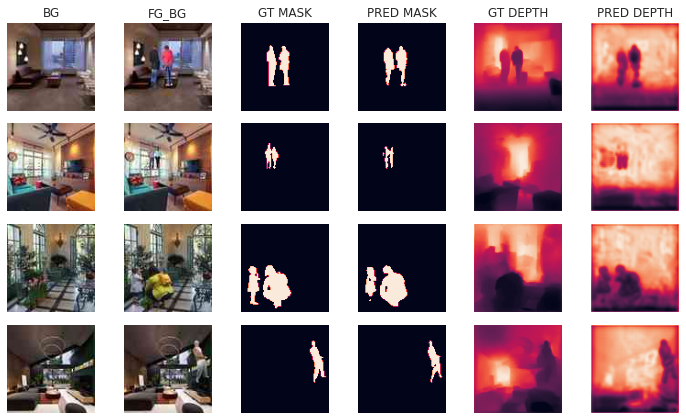

In [0]:
plot_results(results)

### TEST: High Params for Segmentation

`512 -> 256 -> 128 -> 64 -> 32 -> 16 -> 1`


In [0]:
pred, target = test_loss_func(DiceLossV2(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=1)

Experiment, div_factor: 1, batch_size: 128, num_workers: 2



total time : 1171.4645 s
the model took : 1140.0056 s i.e. 0.9731 % of total execution
data loading took : 8.3117 s i.e. 0.0071 % of total execution
inferencing took: 0.6714 s i.e. 0.0006 % of total execution
others took : 19.1772 s i.e. 0.0164 % of total execution


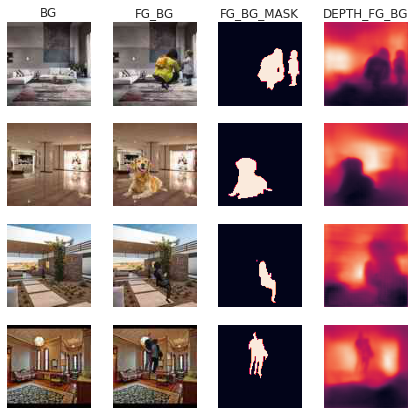

In [0]:
plot4_batch(pred)

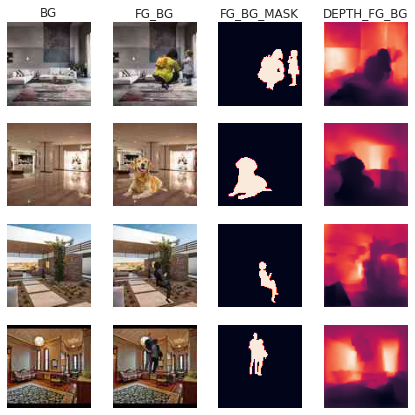

In [0]:
plot4_batch(target)

### TEST: Low Params for Segmentation

`512 -> 64 -> 64 -> 32 -> 16 -> 1`

In [0]:
results = test_loss_func(DiceLossV2(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=1)

Experiment, div_factor: 1, batch_size: 128, num_workers: 2



total time : 1171.4259 s
the model took : 1139.9913 s i.e. 0.9732 % of total execution
data loading took : 8.3079 s i.e. 0.0071 % of total execution
inferencing took: 0.6862 s i.e. 0.0006 % of total execution
others took : 19.2169 s i.e. 0.0164 % of total execution


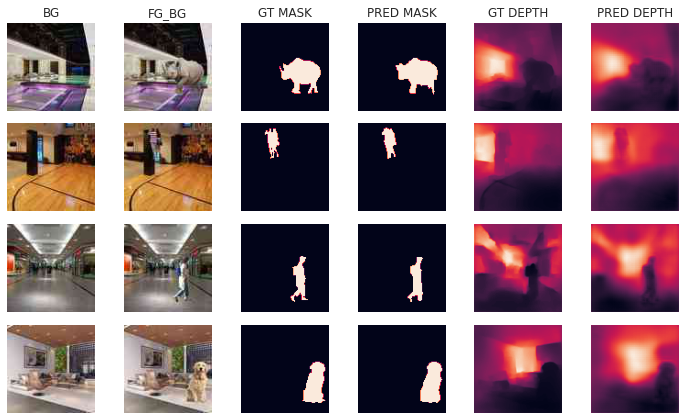

In [0]:
plot_results(results)

# Play with Loss Functions

### Segmentation Losses

In [0]:
results = test_loss_func(nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.12789911031723022
mRMSE : 0.11494194716215134
total time : 196.1347 s
the model took : 142.5627 s i.e. 0.7269 % of total execution
data loading took : 1.0457 s i.e. 0.0053 % of total execution
testing took: 45.1102 s i.e. 0.2300 % of total execution
others took : 2.4603 s i.e. 0.0125 % of total execution


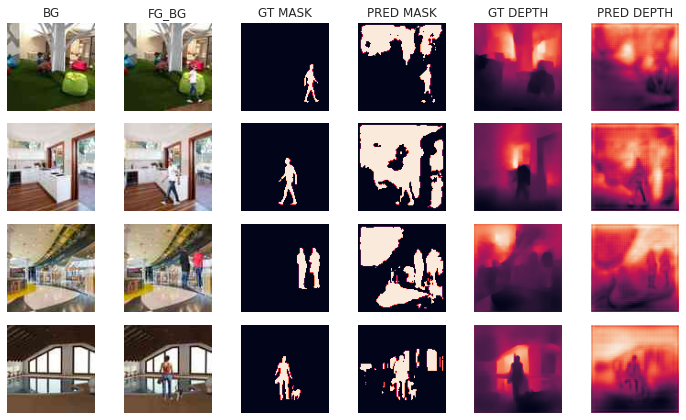

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(DiceLoss(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.4515075087547302
mRMSE : 0.08582810312509537
total time : 193.0364 s
the model took : 142.5006 s i.e. 0.7382 % of total execution
data loading took : 1.0409 s i.e. 0.0054 % of total execution
testing took: 42.2209 s i.e. 0.2187 % of total execution
others took : 2.4448 s i.e. 0.0127 % of total execution


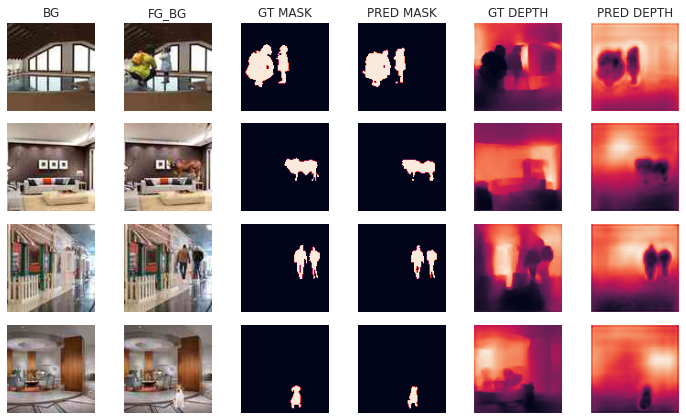

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(TverskyLoss(0.5, 0.5), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.32213953137397766
mRMSE : 0.10182604193687439
total time : 193.5620 s
the model took : 142.5955 s i.e. 0.7367 % of total execution
data loading took : 1.0458 s i.e. 0.0054 % of total execution
testing took: 42.6363 s i.e. 0.2203 % of total execution
others took : 2.4339 s i.e. 0.0126 % of total execution


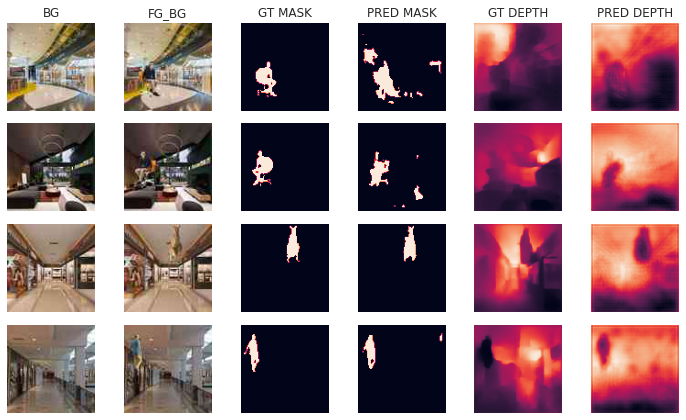

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCEDiceLoss(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.4578476846218109
mRMSE : 0.09939917922019958
total time : 191.8000 s
the model took : 142.6610 s i.e. 0.7438 % of total execution
data loading took : 1.0508 s i.e. 0.0055 % of total execution
testing took: 40.8331 s i.e. 0.2129 % of total execution
others took : 2.4356 s i.e. 0.0127 % of total execution


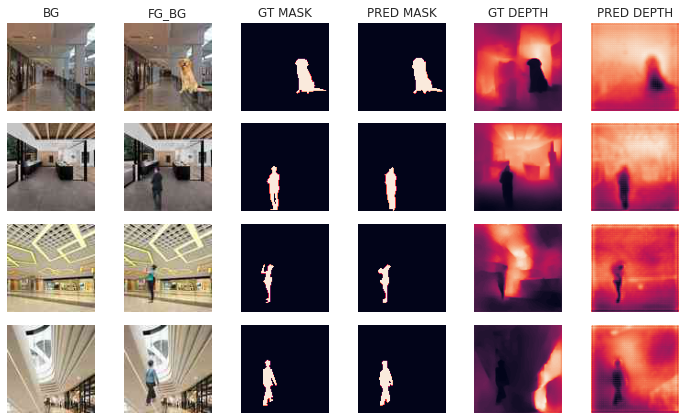

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCETverskyLoss(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.3831656873226166
mRMSE : 0.0936645045876503
total time : 192.6121 s
the model took : 142.7175 s i.e. 0.7410 % of total execution
data loading took : 1.0472 s i.e. 0.0054 % of total execution
testing took: 41.6029 s i.e. 0.2160 % of total execution
others took : 2.4520 s i.e. 0.0127 % of total execution


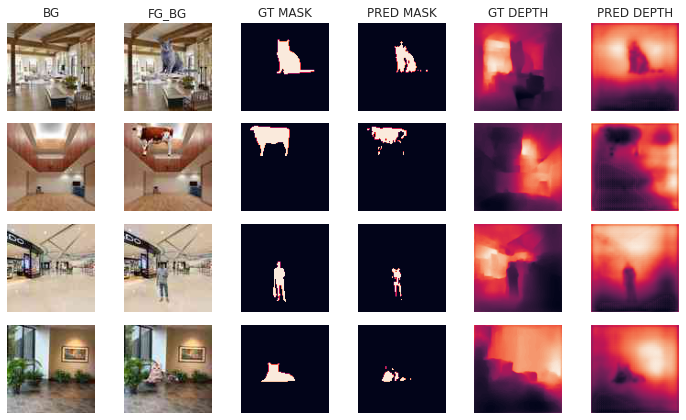

In [0]:
plot_results(results)

### Depth Losses

In [0]:
results = test_loss_func(BCEDiceLoss(), nn.BCEWithLogitsLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.4485453963279724
mRMSE : 0.12491746991872787
total time : 193.3488 s
the model took : 142.6824 s i.e. 0.7380 % of total execution
data loading took : 1.0473 s i.e. 0.0054 % of total execution
testing took: 42.4734 s i.e. 0.2197 % of total execution
others took : 2.4294 s i.e. 0.0126 % of total execution


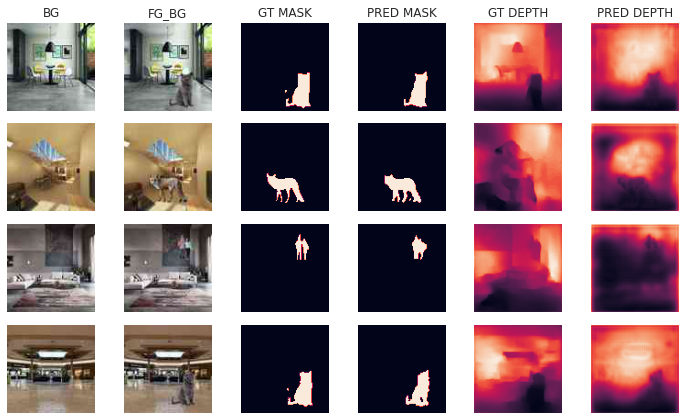

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCEDiceLoss(), BerHuLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.42147812247276306
mRMSE : 0.2882708013057709
total time : 193.7522 s
the model took : 143.0722 s i.e. 0.7384 % of total execution
data loading took : 1.0521 s i.e. 0.0054 % of total execution
testing took: 42.3385 s i.e. 0.2185 % of total execution
others took : 2.4715 s i.e. 0.0128 % of total execution


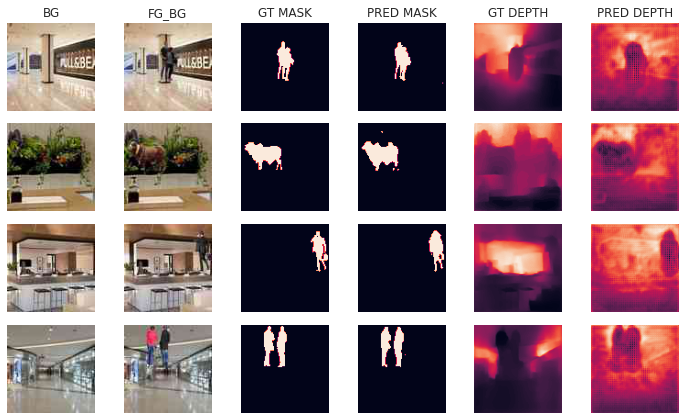

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCEDiceLoss(), RMSELoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.4366089999675751
mRMSE : 0.07745874673128128
total time : 180.7616 s
the model took : 139.7344 s i.e. 0.7730 % of total execution
data loading took : 1.0037 s i.e. 0.0056 % of total execution
testing took: 35.5148 s i.e. 0.1965 % of total execution
others took : 2.0420 s i.e. 0.0113 % of total execution


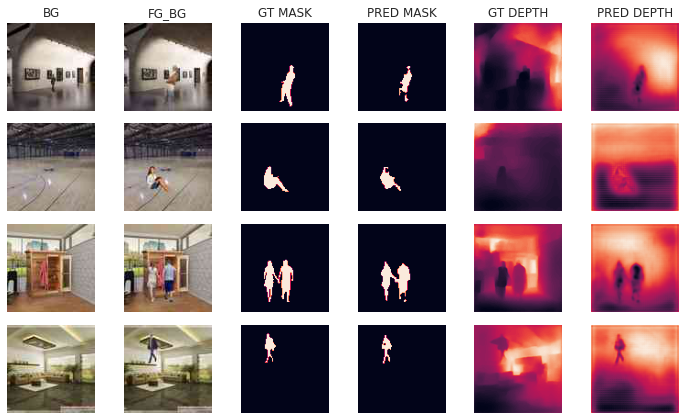

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCEDiceLoss(), GradLoss(), lambda l1, l2: l1 + l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.4542521834373474
mRMSE : 0.1795133352279663
total time : 185.2947 s
the model took : 140.4113 s i.e. 0.7578 % of total execution
data loading took : 0.9754 s i.e. 0.0053 % of total execution
testing took: 39.1682 s i.e. 0.2114 % of total execution
others took : 2.0686 s i.e. 0.0112 % of total execution


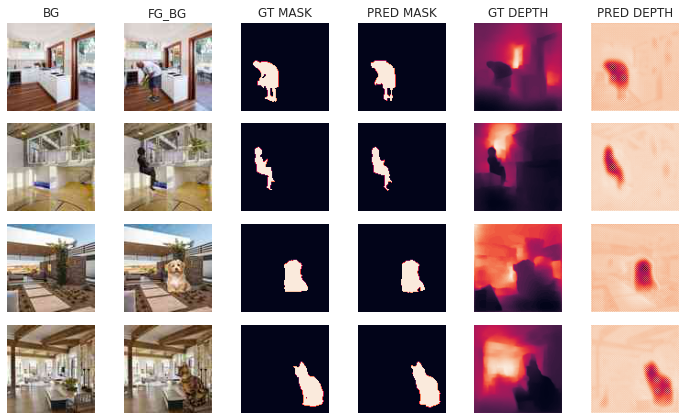

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCEDiceLoss(), SSIMLoss(), lambda l1, l2: l1 + 2*l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.4413087069988251
mRMSE : 0.1304335743188858
total time : 189.7473 s
the model took : 148.6384 s i.e. 0.7833 % of total execution
data loading took : 1.0018 s i.e. 0.0053 % of total execution
testing took: 35.5266 s i.e. 0.1872 % of total execution
others took : 2.0779 s i.e. 0.0110 % of total execution


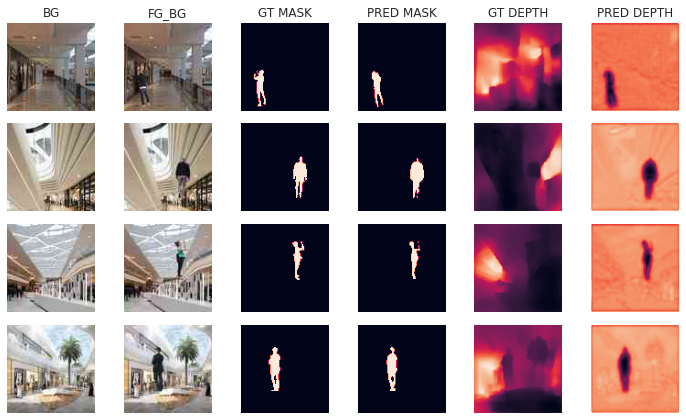

In [0]:
plot_results(results)

In [0]:
results = test_loss_func(BCEDiceLoss(), RMSEwSSIMLoss(), lambda l1, l2: l1 + 2*l2, div_factor=8)

Experiment, div_factor: 8, batch_size: 128, num_workers: 2



mIOU : 0.18217414617538452
mRMSE : 0.1072307750582695
total time : 189.6373 s
the model took : 148.6397 s i.e. 0.7838 % of total execution
data loading took : 1.0050 s i.e. 0.0053 % of total execution
testing took: 35.5280 s i.e. 0.1873 % of total execution
others took : 2.0291 s i.e. 0.0107 % of total execution


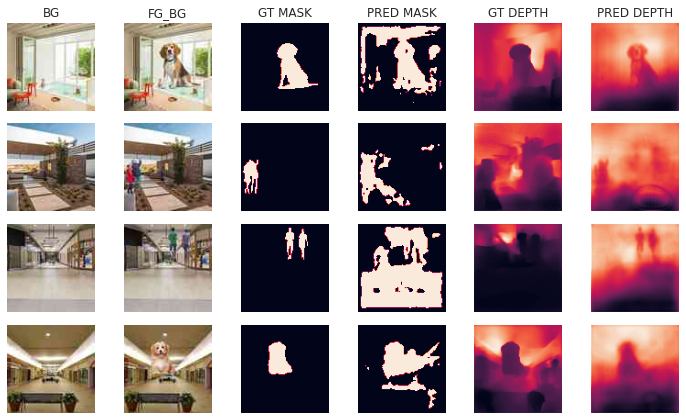

In [0]:
plot_results(results)

# Conclusion

- Segmentation Loss: BCEDiceLoss()
- Depth Loss: RMSELoss()

In [0]:
results = test_loss_func(BCEDiceLoss(), RMSELoss(), lambda l1, l2: l1 + 2*l2, div_factor=1)

Experiment, div_factor: 1, batch_size: 128, num_workers: 2



mIOU : 0.4604145586490631
mRMSE : 0.03332477807998657
total time : 1293.0238 s
the model took : 1117.4782 s i.e. 0.8642 % of total execution
data loading took : 7.9928 s i.e. 0.0062 % of total execution
testing took: 146.8593 s i.e. 0.1136 % of total execution
others took : 16.3528 s i.e. 0.0126 % of total execution


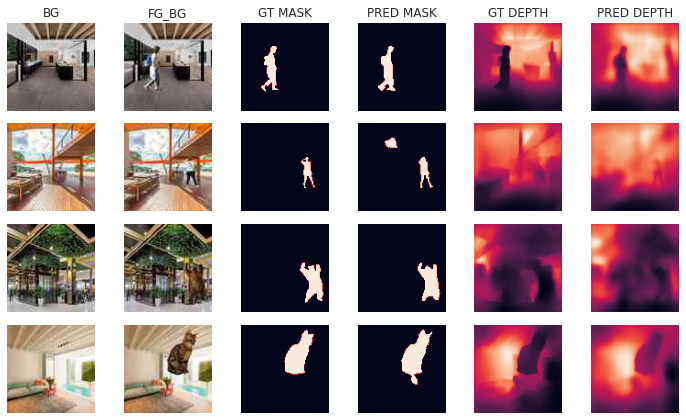

In [0]:
plot_results(results)